In [206]:
from __future__ import division
import numpy as np
from scipy.integrate import odeint, cumtrapz

Integration successful.


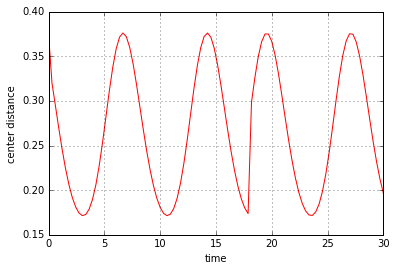

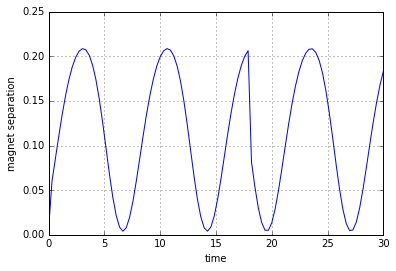

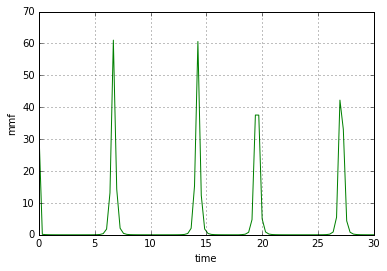

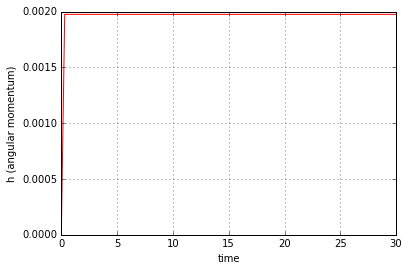

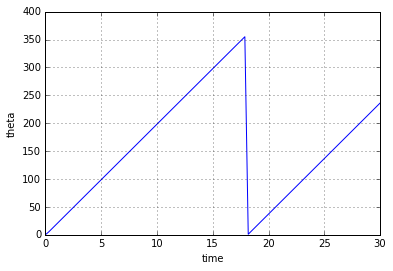

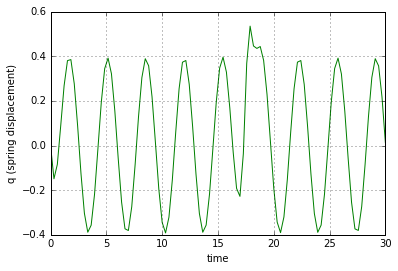

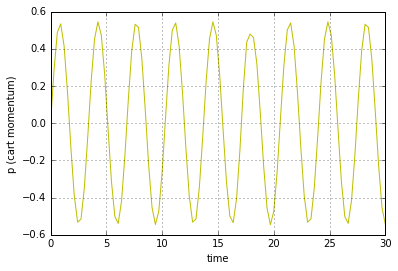

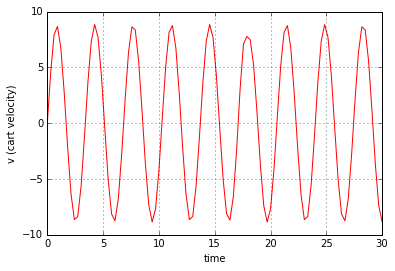

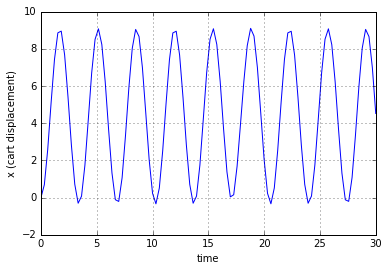

In [207]:
# CONSTANTS
wheel_radius = 0.13 # m 
mag_mass = 0.1133981 # kg - home depot reference
cart_mass = 0.175 - mag_mass # kg
spring_const = 89.1 # N/m => kg/s^2
inertial_mass = 0.5*0.673*wheel_radius**2 # 1/2*wheel_mass*wheel_radius^2
pin_dist = 0.1 # m - distance from center of wheel to rigid arm pin
ra_length = 0.28 # m - length of the rigid arm
rail_height = 0.055 # m - vertical distance from the rail to the center of the wheel

uncompressed_spring_length = 0.05 # m

# MMF specifics
u0 = 4*np.pi*10**-7 # permeability of free space
mag_length = 0.047 # m 
mag_width = 0.022 # m
mag_height = 0.011 # m
mag_radius = mag_height/2 # m - halved height; decide whether this is appropriate
pole_area = mag_length * mag_width # m^2
mag2_dist = ra_length + 0.1 # m - horizontal distance from center of wheel to second magnet (initial)

# INPUT FUNCTIONS
def input_torque(t):
    """
        input torque as a function of time.
    
        Parameters
        ----------
        t : {numpy array}
            timeseries with appropriate range
    """
    if 0.3*t > 7.0*inertial_mass:
        return 0.0
    
    return 7.0*inertial_mass - 0.3*t

def mag_force(theta, show_plots=False):
    """
        repelling force as a function of distance between the two magnets.
        distance between magnets is function of theta.
        
        Parameters
        ----------
        theta : {float} or {numpy.array}
            value of theta at an instantaneous time; if plot=True then this is assumed to be a vector
            of theta values over a given period of time

        show_plots : {bool}, optional
            assumes that theta is passed as vector and thus all corresponding values (e.g. center distance,
            force) are vectors to be plotted against time vector (t)
    """ 
    # compute L - distance from the center of the wheel to the first magnet
    center_dist = pin_dist * np.cos(theta) + \
        np.sqrt(ra_length**2 - (rail_height + pin_dist * np.sin(theta))**2)
        
    # separation between magnets
    sep = mag2_dist - center_dist
    
    # store intermediary caclculations for b0 - cleanliness
    inter = [mag_length*mag_width, mag_length**2, mag_width**2, mag_height + sep]
    
    b0 = 600/10**4
    
    # magnetomotive force - assumes cylindrical bar magnets
    force = ((b0**2 * pole_area**2 * (mag_length**2 + mag_radius**2))/(np.pi*u0 * mag_length**2)) * \
        (1/sep**2 + 1/(sep + 2*mag_length)**2 - 2/(sep + mag_length)**2)
        
        
    if show_plots:    
        # plot center distance, separation, and mmf
        plot.plot(t, center_dist, "r-")
        plot.ylabel("center distance")
        plot.xlabel("time")
        plot.grid()
        plot.show()

        plot.plot(t, sep)
        plot.ylabel("magnet separation")
        plot.xlabel("time")
        plot.grid()
        plot.show()

        plot.plot(t, force, "g-")
        plot.ylabel("mmf")
        plot.xlabel("time")
        plot.grid()
        plot.show()
    
    return force

# SIMULATION
def model(y, t):
    p2, theta, q8, p7 = y
    
    dp2 = input_torque(t) / (1 + (wheel_radius**2)*mag_mass/inertial_mass)
    dtheta = p2/inertial_mass
    dp7 = (mag_force(theta) - q8*spring_const)/(1 + mag_mass/cart_mass)
    dq8 = p7/cart_mass
    
    return [dp2, dtheta, dq8, dp7]

def simulate():
    # initial conditions
    p2_0 = 0.0 # angular momentum (2)
    q8_0 = 0.0 # spring displacement (8)
    p7_0 = 0.0 # momentum (7)
    theta_0 = 0.0 # init angle

    time = np.linspace(0.0, 30.0, 100) # 100 points between 0 and 30 seconds

    y_init = [p2_0, theta_0, q8_0, p7_0]
    
    y = odeint(model, y_init, time, printmessg=True)    
    
    p2 = y[:, 0]
    theta = y[:, 1]
    q8 = y[:, 2]
    p7 = y[:, 3]
    
    theta = map(lambda x: x % 360, np.degrees(theta))
    
    # compute and plot theta-related values
    mag_force(theta, show_plots=True)

    # plot all output variables over time
    plot.plot(t, p2, "r-")
    plot.xlabel("time")
    plot.ylabel("h (angular momentum)")
    plot.legend()
    plot.grid()
    plot.show()
    
    # convert theta to degrees before plotting
    plot.plot(t, theta)
    plot.xlabel("time")
    plot.ylabel("theta")
    plot.grid()
    plot.show()

    plot.plot(t, q8, "g-")
    plot.xlabel("time")
    plot.ylabel("q (spring displacement)")
    plot.grid()
    plot.show()

    plot.plot(t, p7, "y")
    plot.xlabel("time")
    plot.ylabel("p (cart momentum)")
    plot.grid()
    plot.show()
    
    # obtain the velocity of the cart using mass and momentum
    v7 = p7/cart_mass
    
    plot.plot(t, v7, "r")
    plot.xlabel("time")
    plot.ylabel("v (cart velocity)")
    plot.grid()
    plot.show()
    
    # integrate velocity to obtain displacement
    disp = cumtrapz(v7, t, initial=0)
    
    plot.plot(t, disp)
    plot.xlabel("time")
    plot.ylabel("x (cart displacement)")
    plot.grid()
    plot.show()
    
simulate()

In [ ]:
# placeholder